# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from tabulate import tabulate

# Common Functions

In [2]:
# Client

def _clean_client_zeros_to_nan(df):
    df = df.copy()
    for col in ["elapsed_ms", "click_time_ms", "scroll_to_view_ms"]:
        if col in df.columns:
            df.loc[df[col].fillna(0) <= 0.0, col] = np.nan

    s = df["command_type"].astype(str).str.strip()
    s_norm = (s.str.replace(r"[\s_]+", "", regex=True).str.lower())

    cmd_map = {
        "safeclick": "SafeClick",
        "clickcommand": "SafeClick",
        "scrolltoview": "ScrollToView",
        "getscreencontent": "GetScreenContent",
    }
    df["command_type"] = s_norm.map(cmd_map).fillna(s)
    return df

def _add_client_metric(df):
    df = _clean_client_zeros_to_nan(df).copy()
    df["metric_ms"] = df["elapsed_ms"]  # default

    m = df["command_type"].eq("ScrollToView")
    df.loc[m, "metric_ms"] = df.loc[m, "scroll_to_view_ms"].where(
        df.loc[m, "scroll_to_view_ms"].notna(), df.loc[m, "elapsed_ms"]
    )

    m = df["command_type"].eq("SafeClick")
    df.loc[m, "metric_ms"] = (
        df.loc[m, "click_time_ms"]
          .where(df.loc[m, "click_time_ms"].notna(), df.loc[m, "elapsed_ms"])
          .where(lambda s: s.notna(), df.loc[m, "scroll_to_view_ms"])
    )
    return df

def concat_dataframes_client(df_1, df_2):
    df_1 = df_1.copy(); df_1["phone_model"] = "12 Pro Max"
    df_2 = df_2.copy(); df_2["phone_model"] = "16 Plus"
    df_final = pd.concat([df_1, df_2], ignore_index=True)
    df_final = _add_client_metric(df_final)
    return df_final

In [3]:
def client_metric_summary(df_client, metric):
    return (
        df_client
        .groupby(["phone_model","command_type"])[metric]
        .describe()
        .sort_index()
    )

def plot_client_ecdf(df_client):
    plt.figure(figsize=(9,6))
    for (cmd, phone), g in df_client.groupby(["command_type","phone_model"]):
        x = np.sort(g["metric_ms"].dropna().values)
        if len(x) == 0: continue
        y = np.arange(1, len(x)+1) / len(x)
        plt.step(x, y, where="post", label=f"{cmd} • {phone}")
    plt.xlabel("metric_ms")
    plt.ylabel("ECDF")
    plt.title("Client ECDF by command & phone")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_client_occurrence_trend(df_client, window=20, min_points=3):
    df = df_client.copy().sort_index()
    df["occ_idx"] = df.groupby(["phone_model","command_type"]).cumcount()

    plt.figure(figsize=(9,6))
    for (cmd, phone), g in df.groupby(["command_type","phone_model"]):
        g = g.sort_values("occ_idx")
        s = g["metric_ms"]
        if s.notna().sum() < min_points: continue
        roll = s.rolling(window=window, min_periods=min_points).median()
        plt.plot(g["occ_idx"], roll, label=f"{cmd} • {phone}")
    plt.xlabel("Occurrence index")
    plt.ylabel("Rolling median metric_ms")
    plt.title("Client stability by occurrence (rolling median)")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_client_percentiles(df_client):
    percentiles = [50, 90, 95]
    rows = []
    for (cmd, phone), g in df_client.groupby(["command_type","phone_model"]):
        vals = g["metric_ms"].dropna().values
        if len(vals) == 0: continue
        qs = np.percentile(vals, percentiles)
        rows.append({"command_type": cmd, "phone_model": phone,
                     "p50": qs[0], "p90": qs[1], "p95": qs[2]})
    perf = pd.DataFrame(rows)
    perf_melt = perf.melt(id_vars=["command_type","phone_model"],
                          value_vars=["p50","p90","p95"],
                          var_name="percentile", value_name="metric_ms")

    g = sns.catplot(
        data=perf_melt, x="command_type", y="metric_ms",
        hue="phone_model", col="percentile", kind="bar", errorbar=None,
        height=4, aspect=1.1, sharey=False
    )
    g.fig.subplots_adjust(top=0.8)
    g.fig.suptitle("Client latency percentiles")
    plt.show()

def client_ttests(df_client):
    out = []
    for cmd, g in df_client.groupby("command_type"):
        g12 = g[g["phone_model"]=="12 Pro Max"]["metric_ms"].dropna()
        g16 = g[g["phone_model"]=="16 Plus"]["metric_ms"].dropna()
        if len(g12) >= 2 and len(g16) >= 2:
            t, p = ttest_ind(g12, g16, equal_var=False)
            pooled = np.sqrt(((g12.var(ddof=1)*(len(g12)-1)) + (g16.var(ddof=1)*(len(g16)-1))) / (len(g12)+len(g16)-2))
            d = (g12.mean() - g16.mean()) / pooled if pooled > 0 else np.nan
            out.append({"command_type": cmd, "t": t, "p": p, "cohens_d": d,
                        "mean_12pm": g12.mean(), "mean_16plus": g16.mean(),
                        "n_12pm": len(g12), "n_16plus": len(g16)})
    return pd.DataFrame(out).sort_values("p")

def client_metric_summary(df_client, metric):
    return (
        df_client
        .groupby(["phone_model","command_type"])[metric]
        .describe()
        .sort_index()
    )

def plot_client_ecdf(df_client):
    plt.figure(figsize=(9,6))
    for (cmd, phone), g in df_client.groupby(["command_type","phone_model"]):
        x = np.sort(g["metric_ms"].dropna().values)
        if len(x) == 0: continue
        y = np.arange(1, len(x)+1) / len(x)
        plt.step(x, y, where="post", label=f"{cmd} • {phone}")
    plt.xlabel("metric_ms")
    plt.ylabel("ECDF")
    plt.title("Client ECDF by command & phone")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_client_occurrence_trend(df_client, window=20, min_points=3):
    df = df_client.copy().sort_index()
    df["occ_idx"] = df.groupby(["phone_model","command_type"]).cumcount()

    plt.figure(figsize=(9,6))
    for (cmd, phone), g in df.groupby(["command_type","phone_model"]):
        g = g.sort_values("occ_idx")
        s = g["metric_ms"]
        if s.notna().sum() < min_points: continue
        roll = s.rolling(window=window, min_periods=min_points).median()
        plt.plot(g["occ_idx"], roll, label=f"{cmd} • {phone}")
    plt.xlabel("Occurrence index")
    plt.ylabel("Rolling median metric_ms")
    plt.title("Client stability by occurrence (rolling median)")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_client_percentiles(df_client):
    percentiles = [50, 90, 95]
    rows = []
    for (cmd, phone), g in df_client.groupby(["command_type","phone_model"]):
        vals = g["metric_ms"].dropna().values
        if len(vals) == 0: continue
        qs = np.percentile(vals, percentiles)
        rows.append({"command_type": cmd, "phone_model": phone,
                     "p50": qs[0], "p90": qs[1], "p95": qs[2]})
    perf = pd.DataFrame(rows)
    perf_melt = perf.melt(id_vars=["command_type","phone_model"],
                          value_vars=["p50","p90","p95"],
                          var_name="percentile", value_name="metric_ms")

    g = sns.catplot(
        data=perf_melt, x="command_type", y="metric_ms",
        hue="phone_model", col="percentile", kind="bar", errorbar=None,
        height=4, aspect=1.1, sharey=False
    )
    g.fig.subplots_adjust(top=0.8)
    g.fig.suptitle("Client latency percentiles")
    plt.show()

def client_ttests(df_client):
    out = []
    for cmd, g in df_client.groupby("command_type"):
        g12 = g[g["phone_model"]=="12 Pro Max"]["metric_ms"].dropna()
        g16 = g[g["phone_model"]=="16 Plus"]["metric_ms"].dropna()
        if len(g12) >= 2 and len(g16) >= 2:
            t, p = ttest_ind(g12, g16, equal_var=False)
            pooled = np.sqrt(((g12.var(ddof=1)*(len(g12)-1)) + (g16.var(ddof=1)*(len(g16)-1))) / (len(g12)+len(g16)-2))
            d = (g12.mean() - g16.mean()) / pooled if pooled > 0 else np.nan
            out.append({"command_type": cmd, "t": t, "p": p, "cohens_d": d,
                        "mean_12pm": g12.mean(), "mean_16plus": g16.mean(),
                        "n_12pm": len(g12), "n_16plus": len(g16)})
    return pd.DataFrame(out).sort_values("p")


In [4]:
# Server

def concat_dataframes_server(df_1, df_2):
    df_1 = df_1.copy(); df_1["phone_model"] = "12 Pro Max"
    df_2 = df_2.copy(); df_2["phone_model"] = "16 Plus"
    return pd.concat([df_1, df_2], ignore_index=True)

def server_metric_summary(df_server, metric="total_ms"):
    return (
        df_server
        .groupby(["phone_model","command_type"])[metric]
        .describe()
        .sort_index()
    )

def plot_server_percentiles(df_server, metric="total_ms"):
    percentiles = [50, 90, 95]
    rows = []
    for (cmd, phone), g in df_server.groupby(["command_type","phone_model"]):
        vals = g[metric].dropna().values
        if len(vals) == 0: continue
        qs = np.percentile(vals, percentiles)
        rows.append({"command_type": cmd, "phone_model": phone,
                     "p50": qs[0], "p90": qs[1], "p95": qs[2]})
    perf = pd.DataFrame(rows)
    perf_melt = perf.melt(id_vars=["command_type","phone_model"],
                          value_vars=["p50","p90","p95"],
                          var_name="percentile", value_name=metric)
    g = sns.catplot(
        data=perf_melt, x="command_type", y=metric,
        hue="phone_model", col="percentile", kind="bar", errorbar=None,
        height=4, aspect=1.1, sharey=False
    )
    g.fig.subplots_adjust(top=0.8)
    g.fig.suptitle(f"Server {metric} percentiles")
    plt.show()

def plot_server_breakdown(df_server):
    # For GetScreenContent, show stacked bars of stages
    focus = df_server[df_server["command_type"]=="GetScreenContent"].copy()
    parts = ["snapshot_ms","format_ms","find_ms"]
    melted = focus.melt(id_vars=["phone_model"], value_vars=parts,
                        var_name="stage", value_name="ms")
    plt.figure(figsize=(10,6))
    sns.barplot(data=melted, x="phone_model", y="ms", hue="stage", errorbar="sd")
    plt.title("Server stage breakdown: GetScreenContent")
    plt.tight_layout()
    plt.show()

def server_ttests(df_server, metric="total_ms"):
    out = []
    for cmd, g in df_server.groupby("command_type"):
        g12 = g[g["phone_model"]=="12 Pro Max"][metric].dropna()
        g16 = g[g["phone_model"]=="16 Plus"][metric].dropna()
        if len(g12) >= 2 and len(g16) >= 2:
            t, p = ttest_ind(g12, g16, equal_var=False)
            pooled = np.sqrt(((g12.var(ddof=1)*(len(g12)-1)) + (g16.var(ddof=1)*(len(g16)-1))) / (len(g12)+len(g16)-2))
            d = (g12.mean() - g16.mean()) / pooled if pooled > 0 else np.nan
            out.append({"command_type": cmd, "metric": metric,
                        "t": t, "p": p, "cohens_d": d,
                        "mean_12pm": g12.mean(), "mean_16plus": g16.mean(),
                        "n_12pm": len(g12), "n_16plus": len(g16)})
    return pd.DataFrame(out).sort_values("p")

# ts_fts_basal_1

## Logs for 12 Pro Max

### (Client - Python)

In [5]:
df_12_pm_python_fb1 = pd.read_csv('profiling_12pm_client_ts_fts_basal_1.csv')
df_12_pm_python_fb1

,command_type,elapsed_ms,click_time_ms,scroll_to_view_ms
0,ScrollToView,1150.66,NaN,NaN
1,SafeClick,3885.05,2538.98,1061.335167
2,ScrollToView,1052.75,NaN,NaN
3,SafeClick,3244.15,1942.74,1061.706042
4,SafeClick,3285.38,1888.53,1052.414959
...,...,...,...,...
248,SafeClick,2486.84,1158.69,1043.114791
249,SafeClick,2331.75,1144.12,946.910083
250,SafeClick,2878.63,1136.69,1457.797583
251,SafeClick,2594.21,1405.21,941.172250


### (Server - Swift)

In [6]:
df_12_pm_swift_fb1 = pd.read_csv('profiling_12pm_server_ts_fts_basal_1.csv')
df_12_pm_swift_fb1

,command_type,snapshot_ms,format_ms,total_ms,up_ms,down_ms,tapped,scroll_ms,find_ms,tap_ms
0,GetScreenContent,260.208011,6.504059,266.902089,NaN,NaN,NaN,NaN,NaN,NaN
1,GetScreenContent,178.256035,6.258965,184.705973,NaN,NaN,NaN,NaN,NaN,NaN
2,GetScreenContent,201.602936,6.283045,208.075047,NaN,NaN,NaN,NaN,NaN,NaN
3,GetScreenContent,198.939919,5.699992,204.813004,NaN,NaN,NaN,NaN,NaN,NaN
4,GetScreenContent,210.569024,6.325006,217.098951,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3055,GetScreenContent,97.517967,1.725912,99.318981,NaN,NaN,NaN,NaN,NaN,NaN
3056,ClickCommand,NaN,NaN,1867.693901,NaN,NaN,1.0,295.482874,0.0,1015.177011
3057,GetScreenContent,210.455060,5.798936,216.439009,NaN,NaN,NaN,NaN,NaN,NaN
3058,GetScreenContent,200.675964,6.086111,206.936002,NaN,NaN,NaN,NaN,NaN,NaN


## Logs for 16 Plus

### (Client - Python)

In [7]:
df_16_p_python_fb1 = pd.read_csv('profiling_16plus_client_ts_fts_basal_1.csv')
df_16_p_python_fb1

,command_type,elapsed_ms,click_time_ms,scroll_to_view_ms
0,ScrollToView,735.07,NaN,NaN
1,SafeClick,2687.74,1892.61,630.549625
2,ScrollToView,735.15,NaN,NaN
3,SafeClick,2358.69,1502.83,625.539958
4,SafeClick,2111.35,1088.29,843.736584
...,...,...,...,...
248,SafeClick,1619.11,807.63,631.736791
249,SafeClick,1957.86,1039.94,736.465334
250,SafeClick,2221.42,1198.57,846.070750
251,SafeClick,2073.10,1233.79,652.577625


### (Server - Swift)

In [8]:
df_16_p_swift_fb1 = pd.read_csv('profiling_16plus_server_ts_fts_basal_1.csv')
df_16_p_swift_fb1

,command_type,snapshot_ms,format_ms,total_ms,up_ms,down_ms,tapped,scroll_ms,find_ms,tap_ms
0,GetScreenContent,171.721935,3.924012,175.804019,NaN,NaN,NaN,NaN,NaN,NaN
1,GetScreenContent,139.386058,3.714919,143.252015,NaN,NaN,NaN,NaN,NaN,NaN
2,GetScreenContent,136.314988,3.690958,140.172005,NaN,NaN,NaN,NaN,NaN,NaN
3,GetScreenContent,150.521040,2.900958,153.585076,NaN,NaN,NaN,NaN,NaN,NaN
4,GetScreenContent,140.778065,3.733993,144.664049,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3772,GetScreenContent,54.190040,1.034975,55.286050,NaN,NaN,NaN,NaN,NaN,NaN
3773,ClickCommand,NaN,NaN,1156.100988,NaN,NaN,1.0,183.722019,0.0,660.20906
3774,GetScreenContent,124.105096,3.960967,128.246069,NaN,NaN,NaN,NaN,NaN,NaN
3775,GetScreenContent,143.218040,3.965974,147.372961,NaN,NaN,NaN,NaN,NaN,NaN


## Compare Client Logs

count         mean          std      min        25%  \
phone_model command_type                                                        
12 Pro Max  SafeClick     250.0  3478.189600   905.224776  2231.83  3041.1875   
            ScrollToView    3.0  2945.633333  3194.152734  1052.75  1101.7050   
16 Plus     SafeClick     250.0  2479.746560   554.008000  1537.80  2162.9700   
            ScrollToView    3.0  2425.833333  2928.418715   735.07   735.1100   

                               50%        75%       max  
phone_model command_type                                 
12 Pro Max  SafeClick     3462.785  3795.0575  13648.94  
            ScrollToView  1150.660  3892.0750   6633.49  
16 Plus     SafeClick     2431.055  2705.1850   8487.83  
            ScrollToView   735.150  3271.2150   5807.28

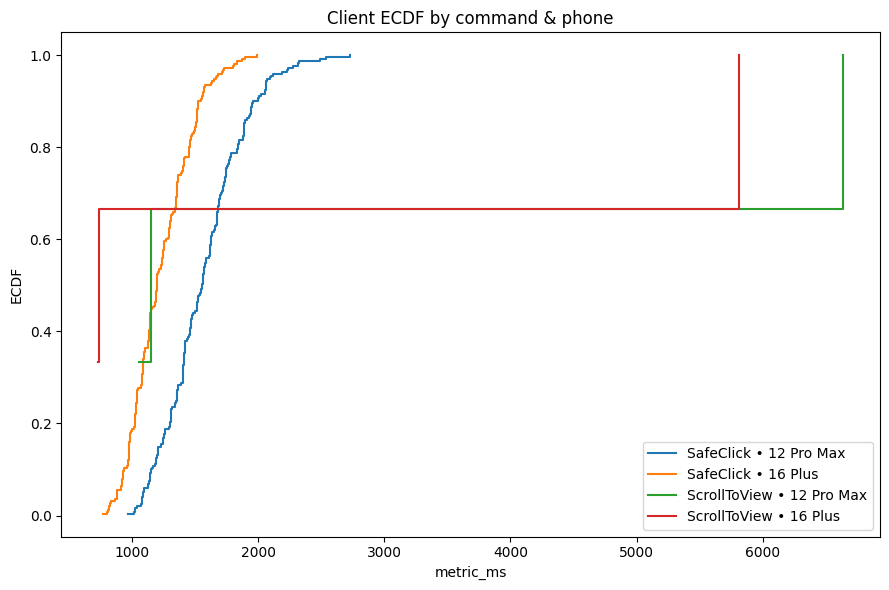

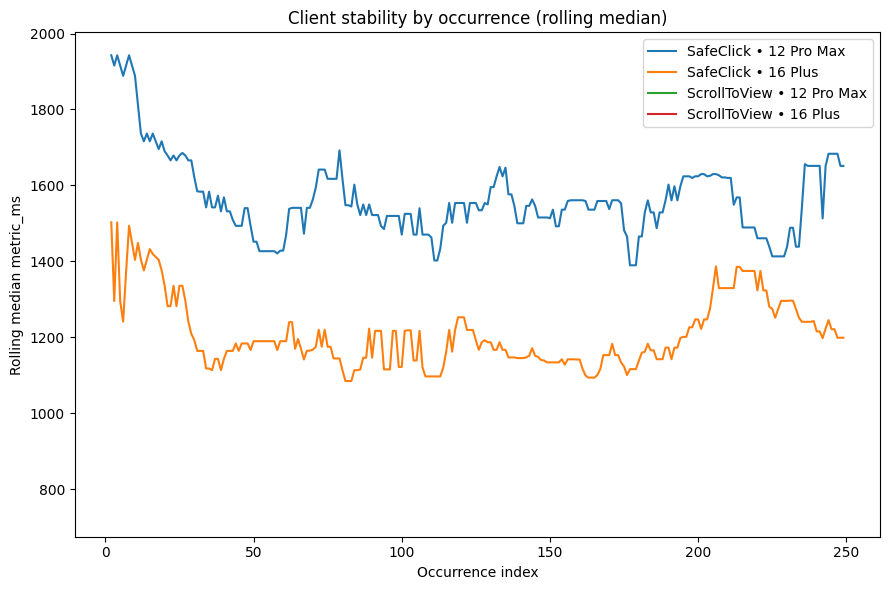

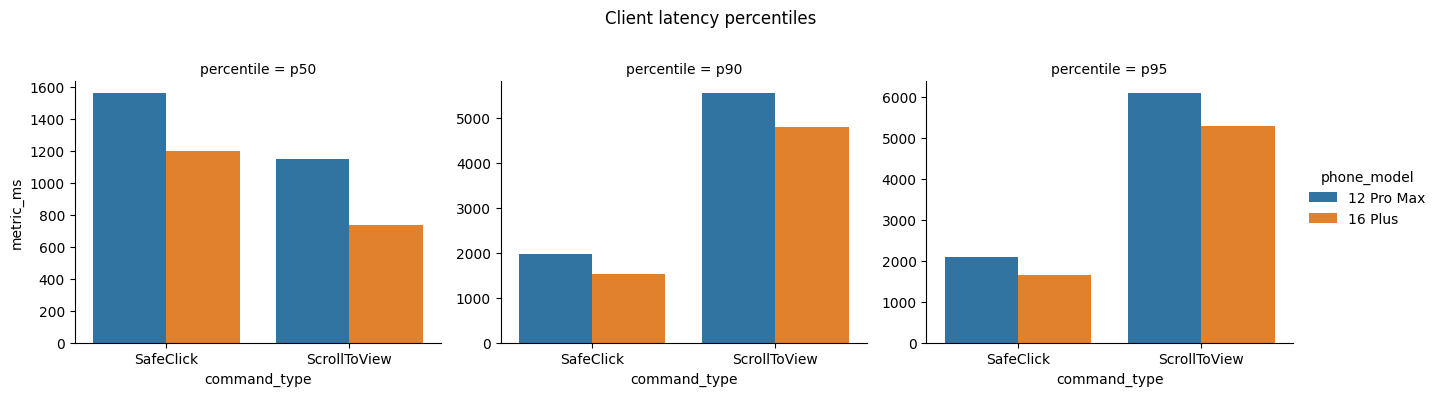

,command_type,t,p,cohens_d,mean_12pm,mean_16plus,n_12pm,n_16plus
0,SafeClick,13.458119,4.115917e-35,1.203731,1569.548680,1231.236480,250,250
1,ScrollToView,0.207764,8.456353e-01,0.169638,2945.633333,2425.833333,3,3


In [9]:
df_client = concat_dataframes_client(df_12_pm_python_fb1, df_16_p_python_fb1)
display(client_metric_summary(df_client, "elapsed_ms"))
plot_client_ecdf(df_client)
plot_client_occurrence_trend(df_client)
plot_client_percentiles(df_client)
display(client_ttests(df_client))

## Compare Server Logs

count         mean         std         min  \
phone_model command_type                                                    
12 Pro Max  ClickCommand       252.0  1496.218450  319.107066  627.271056   
            GetScreenContent  2549.0   248.257949   72.420364   87.525964   
            ScrollToView       259.0  1569.893715  886.886861  848.538041   
16 Plus     ClickCommand       252.0  1163.767805  239.921878  701.434016   
            GetScreenContent  3266.0   157.964922   44.199915   54.544926   
            ScrollToView       259.0   995.495378  706.636328  511.161923   

                                      25%          50%          75%  \
phone_model command_type                                              
12 Pro Max  ClickCommand      1294.805020  1473.403513  1692.739278   
            GetScreenContent   227.146983   240.793943   256.711006   
            ScrollToView      1038.996518  1613.047957  1733.649492   
16 Plus     ClickCommand       984.916508  1128.444493  1335.422784   
            GetScreenContent   141.151488   146.923959   170.477033   
            ScrollToView       676.571012   963.786006  1078.614533   

                                      max  
phone_model command_type                   
12 Pro Max  ClickCommand      2631.008983  
            GetScreenContent   934.786081  
            ScrollToView      9811.088920  
16 Plus     ClickCommand      1882.447004  
            GetScreenContent   619.861960  
            ScrollToView      6656.544924

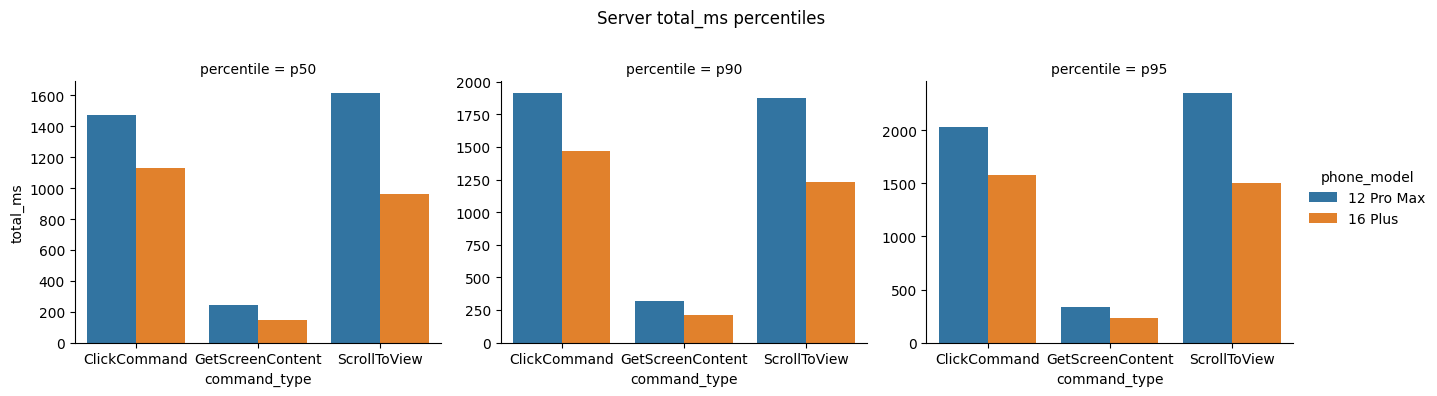

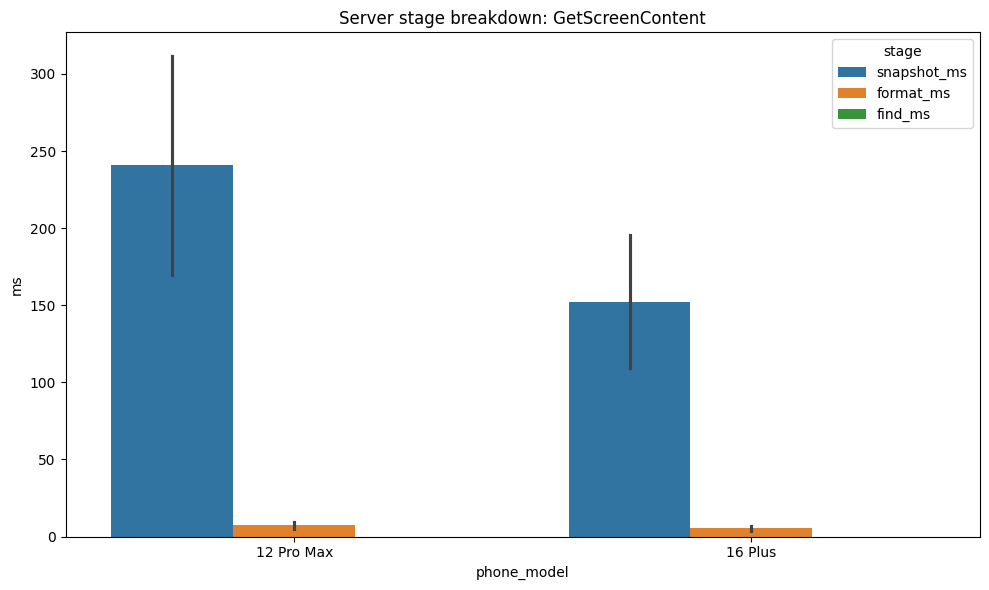

,command_type,metric,t,p,cohens_d,mean_12pm,mean_16plus,n_12pm,n_16plus
1,GetScreenContent,total_ms,55.406713,0.000000e+00,1.549378,248.257949,157.964922,2549,3266
0,ClickCommand,total_ms,13.218873,4.206841e-34,1.177631,1496.218450,1163.767805,252,252
2,ScrollToView,total_ms,8.151901,3.000542e-15,0.716348,1569.893715,995.495378,259,259


In [10]:
df_server = concat_dataframes_server(df_12_pm_swift_fb1, df_16_p_swift_fb1)
display(server_metric_summary(df_server, "total_ms"))
plot_server_percentiles(df_server, "total_ms")
plot_server_breakdown(df_server)
display(server_ttests(df_server, "total_ms"))

# ts_fts_verification

## Logs for 12 Pro Max

### (Client - Python)

In [11]:
df_12_pm_python_fv = pd.read_csv('profiling_12pm_client_ts_fts_verification.csv')
df_12_pm_python_fv

,command_type,elapsed_ms,click_time_ms,scroll_to_view_ms
0,ScrollToView,1051.95,NaN,NaN
1,SafeClick,3726.39,2466.51,1038.798667
2,ScrollToView,1046.00,NaN,NaN
3,SafeClick,2956.65,1729.15,943.030167
4,SafeClick,2707.92,1464.81,954.974750
...,...,...,...,...
81,SafeClick,2477.12,1247.79,945.045750
82,SafeClick,2431.62,1193.43,942.169542
83,SafeClick,2280.30,1040.21,949.890041
84,SafeClick,2432.16,1248.24,943.489792


In [12]:
summary = df_12_pm_python_fv.describe().transpose()
summary

,count,mean,std,min,25%,50%,75%,max
elapsed_ms,86.0,3354.092326,1956.561674,949.110000,2547.292500,3012.435000,3716.357500,12559.390000
click_time_ms,79.0,1642.548228,448.089017,924.290000,1259.790000,1531.250000,1927.125000,2596.840000
scroll_to_view_ms,79.0,1556.042454,1557.674767,838.739041,950.491479,1137.310583,1614.523354,9212.452375


### (Server - Swift)

In [13]:
df_12_pm_swift_fv = pd.read_csv('profiling_12pm_server_ts_fts_verification.csv')
df_12_pm_swift_fv

,command_type,snapshot_ms,format_ms,total_ms,up_ms,down_ms,tapped,scroll_ms,find_ms,tap_ms
0,GetScreenContent,252.188087,6.803989,259.160995,NaN,NaN,NaN,NaN,NaN,NaN
1,GetScreenContent,186.468005,5.908012,192.525983,NaN,NaN,NaN,NaN,NaN,NaN
2,GetScreenContent,202.826977,5.924940,208.904982,NaN,NaN,NaN,NaN,NaN,NaN
3,GetScreenContent,175.944090,6.241918,182.378054,NaN,NaN,NaN,NaN,NaN,NaN
4,GetScreenContent,216.410995,6.040931,222.601891,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1692,GetScreenContent,225.512028,6.268024,231.963992,NaN,NaN,NaN,NaN,NaN,NaN
1693,ScrollToView,NaN,NaN,878.859043,68.150043,0.0,NaN,NaN,NaN,NaN
1694,GetScreenContent,211.632013,6.289959,218.096972,NaN,NaN,NaN,NaN,NaN,NaN
1695,ClickCommand,NaN,NaN,1148.304105,NaN,NaN,1.0,98.520994,0.0,626.70505


In [14]:
summary = df_12_pm_swift_fv.describe().transpose()
summary

,count,mean,std,min,25%,50%,75%,max
snapshot_ms,1512.0,197.134091,54.023674,74.998021,190.601468,198.033512,223.225445,870.967984
format_ms,1512.0,5.446513,1.960162,0.874043,5.782008,6.185532,6.341219,19.976020
total_ms,1697.0,352.662850,602.515017,76.284051,198.101044,208.148003,233.085990,9127.148032
up_ms,98.0,307.661735,1033.898033,55.799961,89.613020,102.278590,114.152491,6246.531963
down_ms,98.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
tapped,87.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
scroll_ms,87.0,239.900519,270.731307,0.000000,97.943962,105.566025,261.605501,1202.162027
find_ms,87.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
tap_ms,87.0,794.311543,271.609718,403.195024,581.831515,789.775014,981.725514,1855.831027


## Logs for 16 Plus

### (Client - Python)

In [15]:
df_16_p_python_fv = pd.read_csv('profiling_16plus_client_ts_fts_verification.csv')
df_16_p_python_fv

,command_type,elapsed_ms,click_time_ms,scroll_to_view_ms
0,ScrollToView,743.99,NaN,NaN
1,SafeClick,2649.90,1838.89,627.792250
2,ScrollToView,634.63,NaN,NaN
3,SafeClick,2280.57,1408.70,632.835083
4,SafeClick,1996.24,1181.86,629.962167
...,...,...,...,...
83,SafeClick,1701.64,824.04,644.671459
84,SafeClick,1955.00,1129.98,640.884542
85,SafeClick,1984.30,1173.28,637.562208
86,SafeClick,1677.54,758.96,740.937709


In [16]:
summary = df_16_p_python_fv.describe().transpose()
summary

,count,mean,std,min,25%,50%,75%,max
elapsed_ms,88.0,2422.176818,1242.400143,634.630000,1842.802500,2316.940000,2659.435000,7919.38000
click_time_ms,81.0,1311.686296,333.419018,758.960000,1036.390000,1343.930000,1573.570000,1989.63000
scroll_to_view_ms,81.0,985.149653,937.783366,528.678625,637.345292,740.192583,1042.041875,5661.64875


### (Server - Swift)

In [17]:
df_16_p_swift_fv = pd.read_csv('profiling_16plus_server_ts_fts_verification.csv')
df_16_p_swift_fv

,command_type,snapshot_ms,format_ms,total_ms,up_ms,down_ms,tapped,scroll_ms,find_ms,tap_ms
0,GetScreenContent,174.860954,4.304051,179.329991,NaN,NaN,NaN,NaN,NaN,NaN
1,GetScreenContent,106.408000,3.826022,110.392094,NaN,NaN,NaN,NaN,NaN,NaN
2,GetScreenContent,141.942978,3.749967,145.849943,NaN,NaN,NaN,NaN,NaN,NaN
3,GetScreenContent,127.616048,3.819942,131.593943,NaN,NaN,NaN,NaN,NaN,NaN
4,GetScreenContent,138.265014,3.782988,142.201066,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1897,GetScreenContent,150.462985,4.014969,154.655933,NaN,NaN,NaN,NaN,NaN,NaN
1898,ScrollToView,NaN,NaN,663.312912,166.079044,0.0,NaN,NaN,NaN,NaN
1899,GetScreenContent,107.133031,3.952980,111.264110,NaN,NaN,NaN,NaN,NaN,NaN
1900,ClickCommand,NaN,NaN,723.821998,NaN,NaN,1.0,58.327913,0.0,405.387044


In [18]:
summary = df_16_p_swift_fv.describe().transpose()
summary

,count,mean,std,min,25%,50%,75%,max
snapshot_ms,1713.0,133.517474,29.574783,46.025038,127.202988,134.297967,142.920017,672.502995
format_ms,1713.0,3.766985,0.950948,0.609994,3.705025,3.746033,3.876090,11.761904
total_ms,1902.0,234.842788,413.479046,47.075033,131.890923,140.667498,148.789734,6293.058991
up_ms,100.0,246.076952,930.583260,30.484915,54.563493,59.259534,71.633577,5759.284973
down_ms,100.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
tapped,89.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
scroll_ms,89.0,141.089863,142.828963,0.000000,60.423970,71.190000,213.199973,611.977935
find_ms,89.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
tap_ms,89.0,700.791297,234.360306,373.520017,464.990973,769.600034,916.962028,1112.675905


## Compare Client Logs

count         mean          std      min       25%  \
phone_model command_type                                                       
12 Pro Max  SafeClick      79.0  3478.077595  1895.524932  2003.96  2587.040   
            ScrollToView    7.0  1954.830000  2244.112367   949.11  1048.975   
16 Plus     SafeClick      81.0  2504.555679  1140.735167  1523.09  1893.490   
            ScrollToView    7.0  1468.935714  1969.646738   634.63   740.385   

                              50%       75%       max  
phone_model command_type                               
12 Pro Max  SafeClick     3123.70  3720.275  12559.39  
            ScrollToView  1163.01  1217.520   7038.70  
16 Plus     SafeClick     2360.64  2688.040   7919.38  
            ScrollToView   743.34   744.535   5934.74

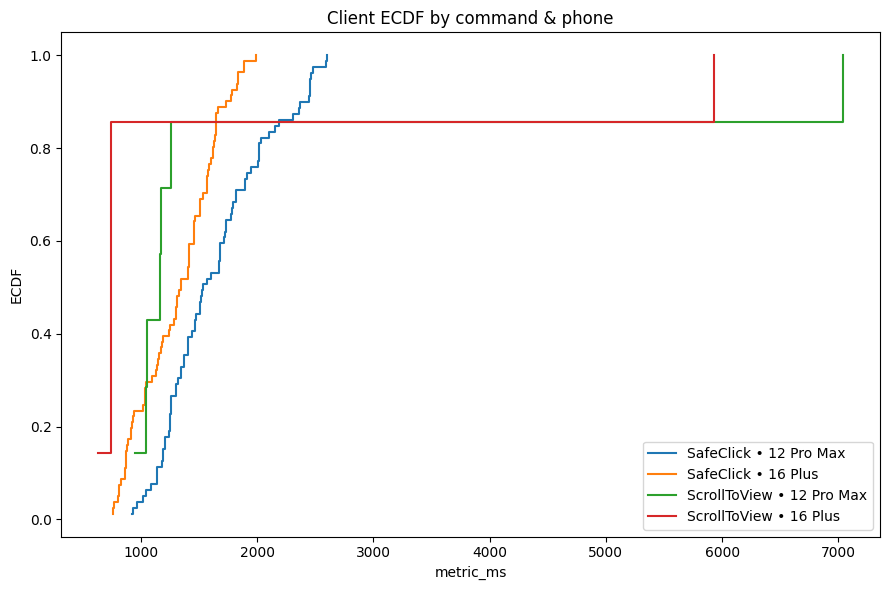

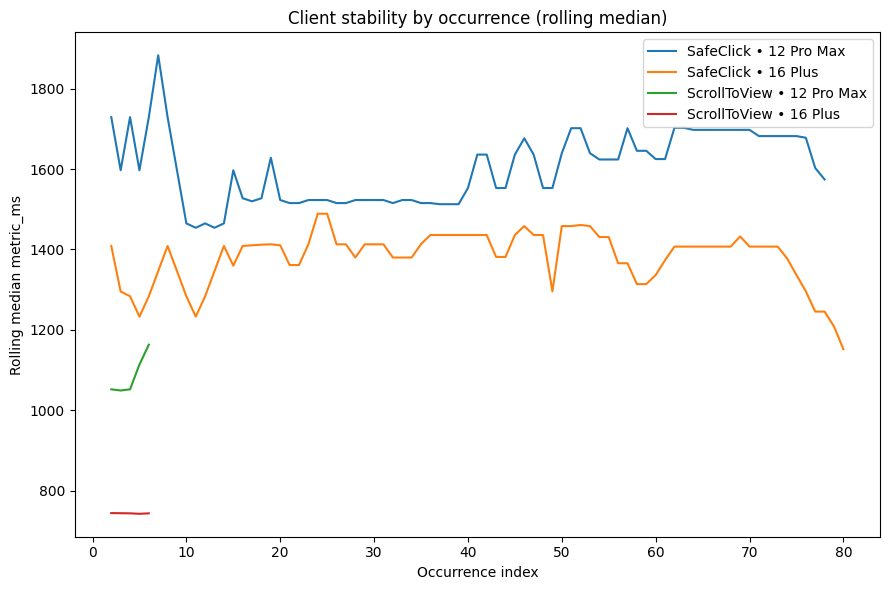

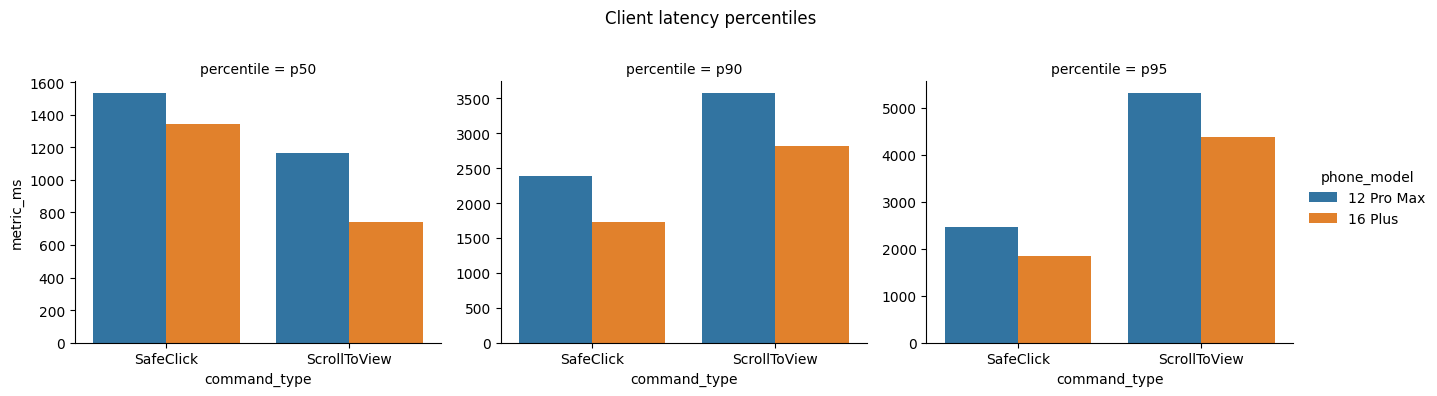

,command_type,t,p,cohens_d,mean_12pm,mean_16plus,n_12pm,n_16plus
0,SafeClick,5.288538,4.486005e-07,0.839284,1642.548228,1311.686296,79,81
1,ScrollToView,0.430543,6.745586e-01,0.230135,1954.830000,1468.935714,7,7


In [19]:
df_client = concat_dataframes_client(df_12_pm_python_fv, df_16_p_python_fv)
display(client_metric_summary(df_client, "elapsed_ms"))
plot_client_ecdf(df_client)
plot_client_occurrence_trend(df_client)
plot_client_percentiles(df_client)
display(client_ttests(df_client))

## Compare Server Logs

count         mean          std         min  \
phone_model command_type                                                     
12 Pro Max  ClickCommand        87.0  1553.276675   441.868104  887.354970   
            GetScreenContent  1512.0   202.744842    55.778016   76.284051   
            ScrollToView        98.0  1599.832498  1706.185355  780.516982   
16 Plus     ClickCommand        89.0  1220.153002   327.697739  682.015061   
            GetScreenContent  1713.0   137.449595    30.329598   47.075033   
            ScrollToView       100.0  1026.262096  1225.536772  460.821033   

                                      25%          50%          75%  \
phone_model command_type                                              
12 Pro Max  ClickCommand      1180.639565  1426.052928  1834.640026   
            GetScreenContent   196.802288   204.418480   229.503036   
            ScrollToView       900.214761  1054.371953  1542.170942   
16 Plus     ClickCommand       957.468987  1217.061996  1491.925955   
            GetScreenContent   131.170988   138.293982   147.087097   
            ScrollToView       549.528033   674.291492   918.697268   

                                      max  
phone_model command_type                   
12 Pro Max  ClickCommand      2519.550085  
            GetScreenContent   889.980078  
            ScrollToView      9127.148032  
16 Plus     ClickCommand      1937.726021  
            GetScreenContent   683.815956  
            ScrollToView      6293.058991

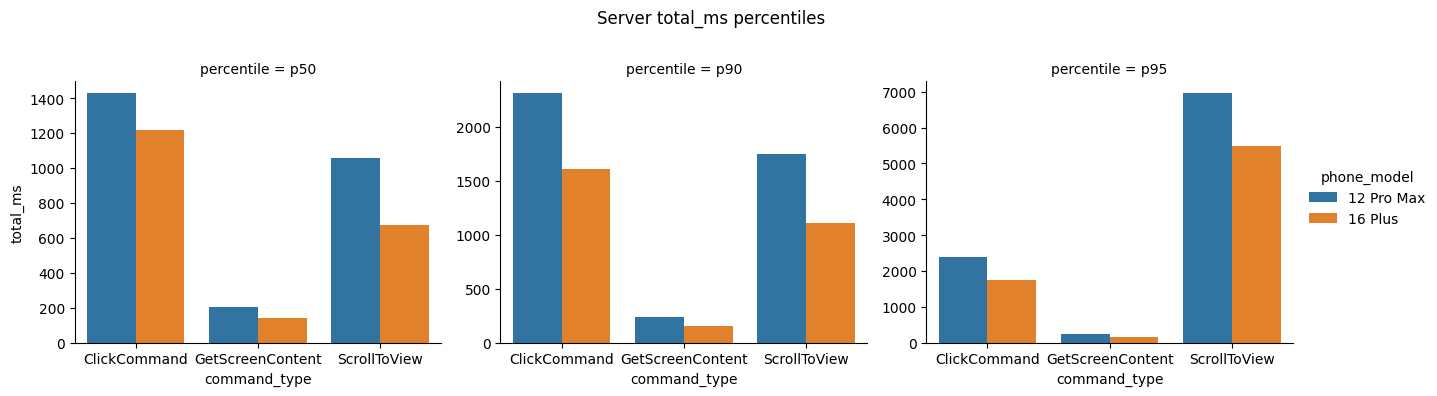

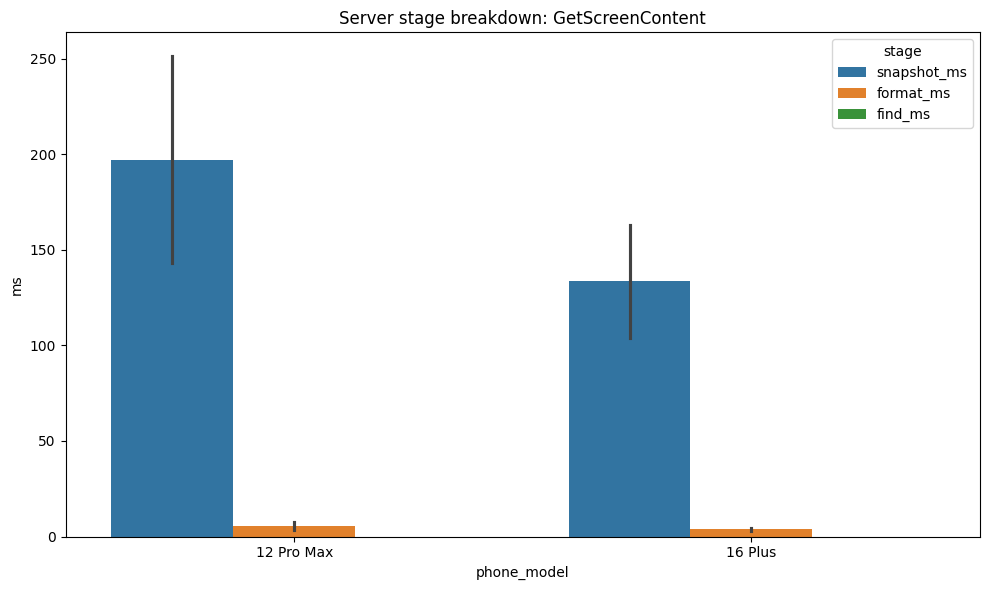

,command_type,metric,t,p,cohens_d,mean_12pm,mean_16plus,n_12pm,n_16plus
1,GetScreenContent,total_ms,40.536000,1.204345e-270,1.479707,202.744842,137.449595,1512,1713
0,ClickCommand,total_ms,5.670812,6.564314e-08,0.857804,1553.276675,1220.153002,87,89
2,ScrollToView,total_ms,2.712161,7.348546e-03,0.386761,1599.832498,1026.262096,98,100


In [20]:
df_server = concat_dataframes_server(df_12_pm_swift_fv, df_16_p_swift_fv)
display(server_metric_summary(df_server, "total_ms"))
plot_server_percentiles(df_server, "total_ms")
plot_server_breakdown(df_server)
display(server_ttests(df_server, "total_ms"))